# Solving SIR model with PINN

In [5]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from SIRData import SIRData
from utils import SINDy_sklearn, sample_collocation_points

## Generate Data from System

In [6]:
# beta1 = 0.2
# beta2 = 0.3
# gamma1 = 1/10
# gamma2 = 1/14

beta = 0.3
gamma = 1/14
theta = 0.01

X0 = torch.tensor([0.99, 0.01, 0.00, 0.00])

In [7]:
time_int = [0, 50]
Nd = 100//7

time_points = np.linspace(time_int[0], time_int[1], Nd+1, endpoint=True)[1:]

# data = SIRData(X0, beta1, beta2, gamma1, gamma2, time_int, N=1000, time_points=time_points)
data = SIRData(X0, beta, gamma, theta, time_int, N=1000, time_points=time_points)
td = data.td
Xd = data.Xd

In [8]:
Xd = torch.cat([Xd[:, 1:2]/10, Xd[:, 3:4]], dim=1)

In [9]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0.reshape(-1, 4)

In [10]:
# Collocation points
N_coll = 1000
tc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

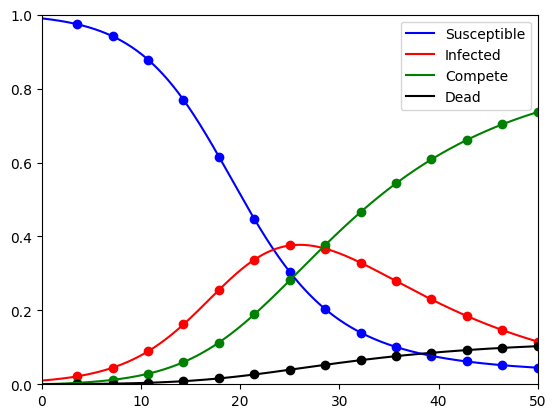

In [11]:
plt.plot(data.t_full, data.X_full[:,0], label='Susceptible', color='blue')
plt.plot(data.t_full, data.X_full[:,1], label='Infected', color='red')
plt.plot(data.t_full, data.X_full[:,2], label='Compete', color='green')
plt.plot(data.t_full, data.X_full[:,3], label='Dead', color='black')
plt.scatter(td, data.Xd[:,0], color='blue')
plt.scatter(td, data.Xd[:,1], color='red')
plt.scatter(td, data.Xd[:,2], color='green')
plt.scatter(td, data.Xd[:,3], color='black')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.ylim(0,1)
plt.legend()
plt.show()

### Known system $N_K$

In [275]:
class SIR(torch.nn.Module):
    
    def __init__(self, params):
        super(SIR, self).__init__()
        
        # Set the parameters
        for key, value in params.items():
            setattr(self, key, value) 

    def forward(self, z, U):

        lhs = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        # rhs = torch.stack([
        #     - self.beta1 * U[:, 0] * U[:, 1] - self.beta2 * U[:, 0] * U[:, 2],
        #     self.beta1 * U[:, 0] * U[:, 1] - self.gamma1 * U[:, 1],
        #     self.beta2 * U[:, 0] * U[:, 2] - self.gamma2 * U[:, 2],
        #     self.gamma1 * U[:, 1] + self.gamma2 * U[:, 1]
        # ], dim=-1)

        # S = U[:, 0]
        # I1 = U[:, 1]
        # I2 = U[:, 2]
        # R = U[:, 3]

        # rhs = torch.stack([
        #     -self.beta1*S*I1,
        #     self.beta1*S*I1 - self.gamma1*I1,
        #     -self.gamma2*I2,
        #     self.gamma1*I1 + self.gamma2*I2
        # ], dim=-1)

        S = U[:, 0]
        I = U[:, 1]
        R = U[:, 2]
        D = U[:, 3]

        rhs = torch.stack([
            -self.beta*S*I,
            self.beta*S*I - self.gamma*I - self.theta*I,
            self.gamma*I,
            self.theta*I
        ], dim=-1)

        norm = torch.maximum(torch.abs(lhs), torch.abs(rhs)) + 1e-6

        return lhs - rhs


params = dict(
    beta=beta,
    gamma=gamma,
    theta=theta
)

# params = dict(
#     beta1 = beta1,
#     beta2 = beta2,
#     gamma1 = gamma1,
#     gamma2 = gamma2
# )

N = SIR(params)

### Problem specific UPINN functions

In [276]:
phi = torch.nn.Parameter(torch.tensor(0.0))

class SIR_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
    
    def F_input(self, z, U):
        return U

    # def get_loss(self):
    #     bc_loss = self.bc_loss()
    #     data_loss = self.data_loss()
    #     pde_loss = self.pde_loss()

    #     u_pred = self.u(self.collocation_points)
    #     population_loss = torch.mean((1 - torch.sum(u_pred, dim=1))**2)
        
    #     loss = self.lambdas[0]*bc_loss + self.lambdas[1]*data_loss + self.lambdas[2]*pde_loss + 1e-3*population_loss

    #     return loss, bc_loss, data_loss, pde_loss
    
    def data_loss(self):
        u_pred = self.u(self.data_points[0])
        
        # I_loss = torch.nn.MSELoss()(u_pred[:,1], self.data_points[1][:,1]*self.dark)

        # I_true = self.data_points[1][:,1]+self.data_points[1][:,2]
        # I_pred = u_pred[:,1]+u_pred[:,2]

        # S_loss = torch.nn.MSELoss()(u_pred[:,0], self.data_points[1][:,0])
        I_loss = torch.nn.MSELoss()(u_pred[:,1]*phi, self.data_points[1][:,0])
        R_loss = torch.nn.MSELoss()(u_pred[:,3], self.data_points[1][:,1])

        return I_loss + R_loss


    # def pde_loss(self):
    #     if self.collocation_points is not None:
    #         U_c = self.u(self.collocation_points)
    #         res = self.F(self.F_input(self.collocation_points, U_c))
    #         known = self.N(self.collocation_points, U_c)
    #         # res = torch.cat([torch.nn.Softplus()(res[:, 0:1]), res[:, 1:2], res[:, 2:3], -torch.nn.Softplus()(res[:, 3:4])], dim=1)

    #         dresdt = torch.cat([
    #         torch.autograd.grad(outputs=U_c[:, i], inputs=self.collocation_points, grad_outputs=torch.ones_like(U_c[:, i]), create_graph=True)[0]
    #         for i in range(U_c.shape[1])
    #         ], dim=-1)

    #         pop_loss3 = torch.max(torch.nn.ReLU()(dresdt[:, 0])) + torch.max(torch.nn.ReLU()(-dresdt[:, 3]))

    #         pop_loss1 = torch.mean((torch.sum(res, dim=1))**2)
    #         pop_loss2 = torch.mean((1.0-torch.sum(U_c, dim=1))**2)


            
    #         pde_loss = torch.nn.MSELoss()(known, -res) + pop_loss1 + pop_loss2 + pop_loss3 if self.collocation_points.shape[0] > 0 else torch.tensor(0.0)
    #     else: pde_loss = torch.tensor(0.0)
    #     return pde_loss
    
    def bc_loss(self):
        if self.boundary_points is not None:
            U_bc = self.u(self.boundary_points[0])
            bc_loss = torch.nn.MSELoss()(U_bc, self.boundary_points[1])
        else: bc_loss = torch.tensor(0.0)
        return bc_loss

    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            # Get network predictions
            u_pred = self.u(data.t_full)

            plt.plot(data.t_full, data.X_full[:,0], label='S', linestyle='--', color='b')
            plt.plot(data.t_full, data.X_full[:,1], label='I1', linestyle='--', color='y')
            plt.plot(data.t_full, data.X_full[:,2], label='I2', linestyle='--', color='g')
            plt.plot(data.t_full, data.X_full[:,3], label='R', linestyle='--', color='r')
            plt.plot(data.t_full, u_pred[:,0].numpy(), color='b')
            plt.plot(data.t_full, u_pred[:,1].numpy(), color='y')
            plt.plot(data.t_full, u_pred[:,2].numpy(), color='g')
            plt.plot(data.t_full, u_pred[:,3].numpy(), color='r')
            plt.legend()
            plt.show()



### Setup UPINN

In [277]:
class SIRNet(FNN):
    def forward(self, z):
        z = (z - td.min()) / (td.max() - td.min())
        z = super().forward(z)
        z = torch.nn.functional.softplus(z)
        return z / torch.sum(z, dim=1, keepdim=True)

# class SIRResidual(FNN):
#     def forward(self, z):
#         z = super().forward(z)
#         # Apply softplus to first and last component
#         z = torch.cat([torch.nn.functional.softplus(z[:,0:1]), torch.zeros_like(z[:,1:2]), z[:,1:2], -torch.nn.functional.softplus(z[:,-1:])], dim=1)
#         return z

class SIRResidual(FNN):
    def forward(self, z):
        z = super().forward(z)
        # Apply softplus to first and last component
        z = torch.cat([torch.nn.functional.softplus(z[:,0:1]), z[:,1:2], -torch.nn.functional.softplus(z[:,2:3]), -torch.nn.functional.softplus(z[:,3:4])], dim=1)
        return z



In [278]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 4],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Softmax(),
)

F = SIRResidual(
    dims=[4, *hidden, 4],
    hidden_act=torch.nn.Tanh(),
)

In [279]:
model = SIR_UPINN(u, N, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=tc)
# model = SIR_UPINN(u, N, F, data_points=(td, Xd), collocation_points=tc)
# model = SIR_UPINN(u, N, F, boundary_points=(tbc, Xbc), collocation_points=tc)
# model.set_dark()

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


### Train

In [280]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
model.optimizer = adamw

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:17<00:00, 58.61 epoch/s, bc_loss=1.47e-05, data_loss=5.73e-04, pde_loss=1.39e-05, loss=6.02e-04]


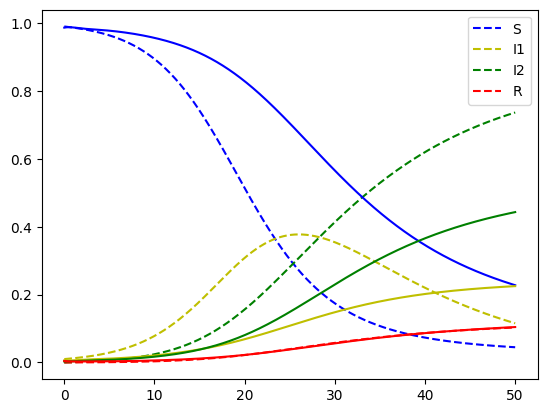

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 61.63 epoch/s, bc_loss=8.61e-06, data_loss=5.72e-04, pde_loss=1.00e-05, loss=5.91e-04]


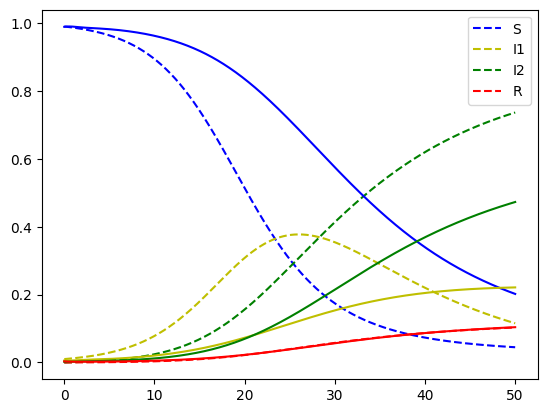

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 60.93 epoch/s, bc_loss=5.09e-06, data_loss=5.71e-04, pde_loss=8.74e-06, loss=5.85e-04]


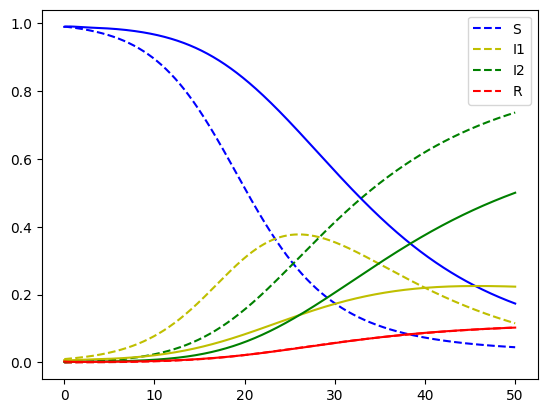

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 59.35 epoch/s, bc_loss=2.88e-06, data_loss=5.71e-04, pde_loss=8.43e-06, loss=5.82e-04]


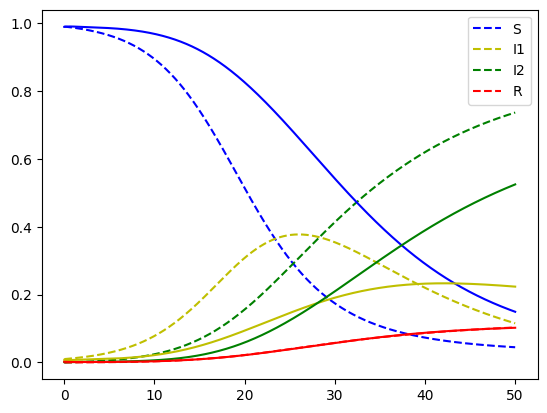

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 59.14 epoch/s, bc_loss=1.69e-06, data_loss=5.71e-04, pde_loss=8.03e-06, loss=5.81e-04]


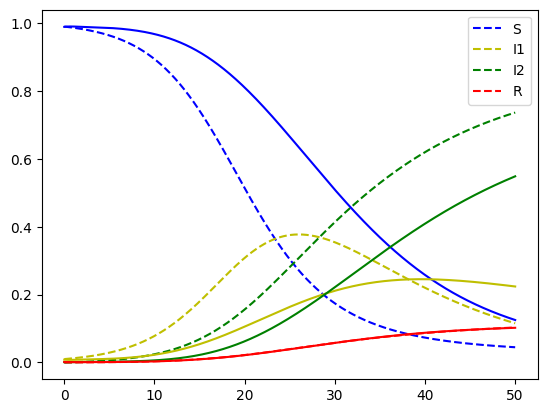

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 59.13 epoch/s, bc_loss=9.02e-07, data_loss=5.71e-04, pde_loss=6.47e-06, loss=5.78e-04]


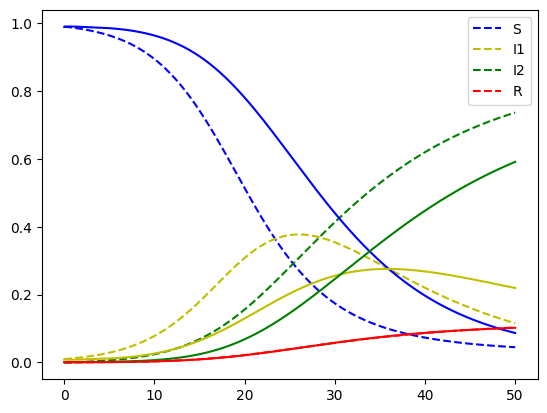

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:17<00:00, 58.37 epoch/s, bc_loss=3.46e-07, data_loss=5.71e-04, pde_loss=1.14e-06, loss=5.72e-04]


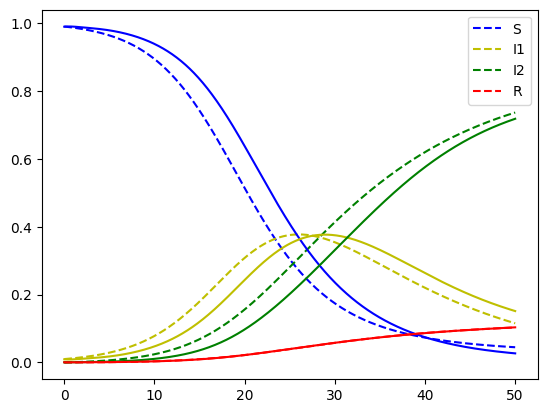

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:17<00:00, 57.05 epoch/s, bc_loss=2.12e-07, data_loss=5.71e-04, pde_loss=7.37e-07, loss=5.72e-04]


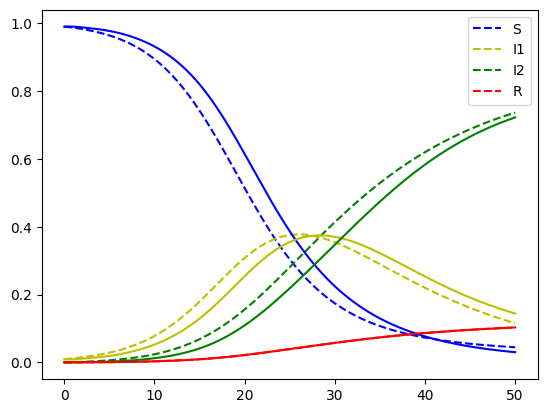

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:18<00:00, 54.80 epoch/s, bc_loss=1.28e-07, data_loss=5.71e-04, pde_loss=5.56e-07, loss=5.71e-04]


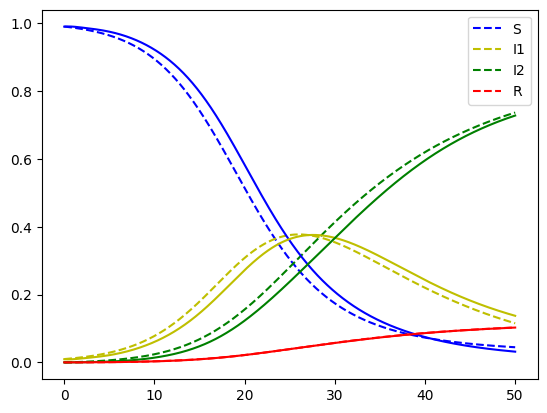

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:17<00:00, 56.32 epoch/s, bc_loss=8.27e-08, data_loss=5.71e-04, pde_loss=4.41e-07, loss=5.71e-04]


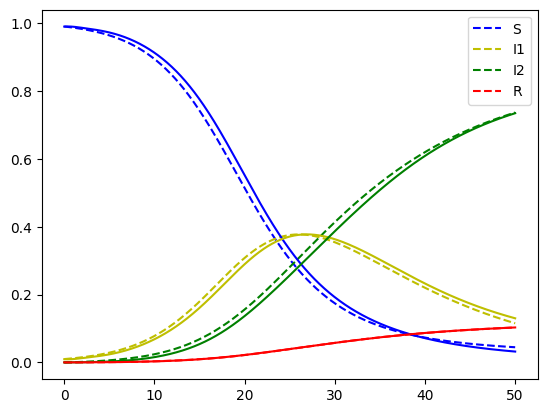

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:18<00:00, 53.35 epoch/s, bc_loss=5.93e-08, data_loss=5.71e-04, pde_loss=3.53e-07, loss=5.71e-04]


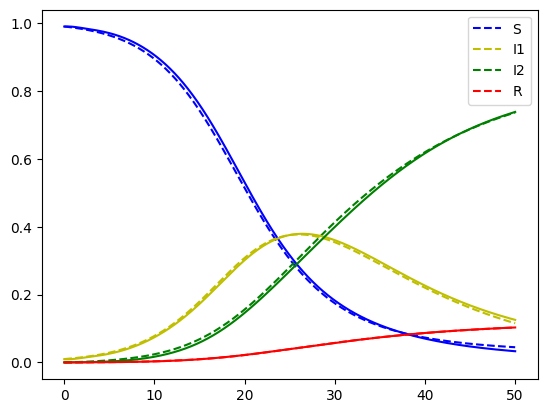

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:18<00:00, 54.82 epoch/s, bc_loss=4.75e-08, data_loss=5.71e-04, pde_loss=2.61e-07, loss=5.71e-04]


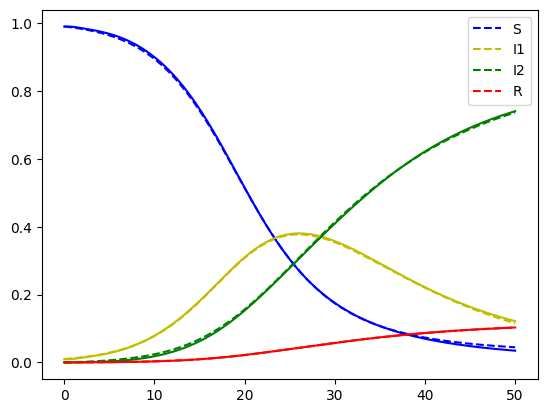

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]:  22%|██▎       | 225/1000 [00:04<00:14, 52.66 epoch/s, bc_loss=4.61e-08, data_loss=5.71e-04, pde_loss=2.37e-07, loss=5.71e-04]


KeyboardInterrupt: 

In [281]:
for i in range(20):
    model.train_loop(1000)
    model.plot()

In [ ]:
model.N.phi

Parameter containing:
tensor(0.2865, device='cuda:0', requires_grad=True)

In [ ]:
# model.save('sir_upinn', 'models')

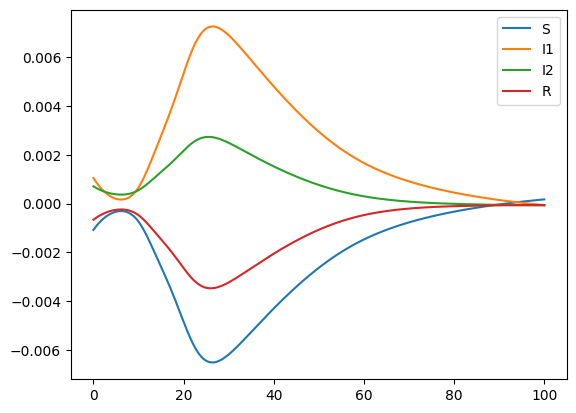

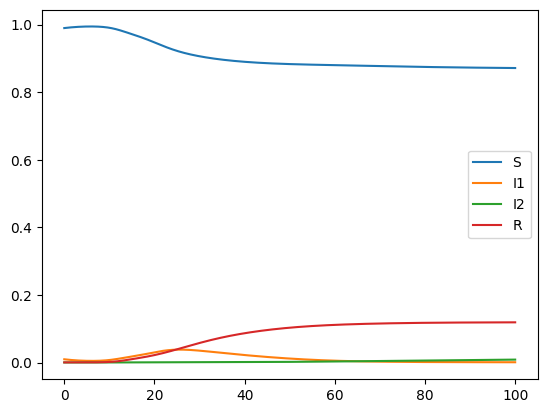

In [ ]:
model.to('cpu')
u_pred = model.u(data.t_full)
res_pred = model.F(model.F_input(data.t_full, u_pred)).detach().numpy()

plt.plot(data.t_full, res_pred[:,0], label='S')
plt.plot(data.t_full, res_pred[:,1], label='I1')
plt.plot(data.t_full, res_pred[:,2], label='I2')
plt.plot(data.t_full, res_pred[:,3], label='R')
plt.legend()
plt.show()

plt.plot(data.t_full, u_pred[:,0].detach(), label='S')
plt.plot(data.t_full, u_pred[:,1].detach(), label='I1')
plt.plot(data.t_full, u_pred[:,2].detach(), label='I2')
plt.plot(data.t_full, u_pred[:,3].detach(), label='R')
plt.legend()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pysindy as ps

In [ ]:
# Generate data from the solution network
t = torch.linspace(0, 20, 100).reshape(-1, 1)
X = model.u(t)
X_dot = model.F(model.F_input(None, X))
t = t.detach().numpy()
X = X.detach().numpy()
X_dot = X_dot.detach().numpy()
# X_dot[:, 2] *= 0 # Recovered does not affect the dynamics

In [ ]:
# Hyperparameter tuning using Crossvalidation with TimeSeriesSplit
sindy_model = SINDy_sklearn(feature_names=['S', 'I1', 'I2', 'R'], feature_library=ps.PolynomialLibrary(degree=2), optimizer=ps.SR3(thresholder="L1", max_iter=1000000, normalize_columns=True))
paramgrid = dict(optimizer__threshold=np.linspace(0.0, 1.0, 100))

cv_folds = TimeSeriesSplit(n_splits=5)
model_selector = GridSearchCV(sindy_model, param_grid=paramgrid, cv=cv_folds, n_jobs=-1)
wrapped_input = np.concatenate([t, X], axis=1)
model_selector.fit(wrapped_input, X_dot)
best_model = model_selector.best_estimator_
best_model.print()

(S)' = 0.000
(I1)' = 0.036 1 + -0.031 S + 0.160 I1 + -0.053 I2 + -0.037 R + -0.005 S^2 + -0.072 S I1 + 0.024 S I2 + 0.022 S R + 0.193 I1^2 + 0.020 I1 I2 + 0.020 I1 R + -0.054 I2^2 + -0.043 I2 R + -0.035 R^2
(I2)' = -0.001 1 + -0.001 I1 + -0.001 I1^2
(R)' = 0.000


In [ ]:
# Hyperparameter tuning using Crossvalidation with TimeSeriesSplit
sindy_model = SINDy_sklearn(feature_names=['S', 'I1', 'I2', 'R'], feature_library=ps.PolynomialLibrary(degree=2), optimizer=ps.SR3(thresholder="L1", max_iter=100000, threshold=0.005, normalize_columns=True))
sindy_model.fit(wrapped_input, X_dot)
sindy_model.print()

(S)' = 0.000
(I1)' = 0.000
(I2)' = 0.000
(R)' = 0.000


In [ ]:
best_model.optimizer.threshold

0.0

In [ ]:
np.linspace(0.0, 0.1, 100)

array([0.        , 0.0010101 , 0.0020202 , 0.0030303 , 0.0040404 ,
       0.00505051, 0.00606061, 0.00707071, 0.00808081, 0.00909091,
       0.01010101, 0.01111111, 0.01212121, 0.01313131, 0.01414141,
       0.01515152, 0.01616162, 0.01717172, 0.01818182, 0.01919192,
       0.02020202, 0.02121212, 0.02222222, 0.02323232, 0.02424242,
       0.02525253, 0.02626263, 0.02727273, 0.02828283, 0.02929293,
       0.03030303, 0.03131313, 0.03232323, 0.03333333, 0.03434343,
       0.03535354, 0.03636364, 0.03737374, 0.03838384, 0.03939394,
       0.04040404, 0.04141414, 0.04242424, 0.04343434, 0.04444444,
       0.04545455, 0.04646465, 0.04747475, 0.04848485, 0.04949495,
       0.05050505, 0.05151515, 0.05252525, 0.05353535, 0.05454545,
       0.05555556, 0.05656566, 0.05757576, 0.05858586, 0.05959596,
       0.06060606, 0.06161616, 0.06262626, 0.06363636, 0.06464646,
       0.06565657, 0.06666667, 0.06767677, 0.06868687, 0.06969697,
       0.07070707, 0.07171717, 0.07272727, 0.07373737, 0.07474